<a href="https://colab.research.google.com/github/ErickMartinezz/AprendizajeAutomatico2/blob/main/RL_TP1_entorno_discreto_FrozenLake_ErickMart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Aprendizaje por Refuerzo en FrozenLake

## Instalar librerias

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Reproducibilidad

In [2]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Crear el entorno

In [3]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='ansi')
print("🏔️ ENTORNO FROZENLAKE")
print("=" * 50)
print(f"Número de estados: {env.observation_space.n}")
print(f"Número de acciones: {env.action_space.n}")
print(f"Acciones: {['Izquierda', 'Abajo', 'Derecha', 'Arriba']}")

🏔️ ENTORNO FROZENLAKE
Número de estados: 16
Número de acciones: 4
Acciones: ['Izquierda', 'Abajo', 'Derecha', 'Arriba']


## Mostrar el mapa

In [4]:
print("\n🗺️ MAPA DEL ENTORNO:")
env.reset()
print(env.render())
print("\nLeyenda:")
print("S = Start (Inicio)")
print("F = Frozen (Hielo seguro)")
print("H = Hole (Hoyo - termina episodio)")
print("G = Goal (Objetivo - +1 recompensa)")


🗺️ MAPA DEL ENTORNO:

SFFF
FHFH
FFFH
HFFG


Leyenda:
S = Start (Inicio)
F = Frozen (Hielo seguro)
H = Hole (Hoyo - termina episodio)
G = Goal (Objetivo - +1 recompensa)


## Función para convertir estado numérico a posición (fila, columna)

In [5]:

def estado_a_posicion(estado):
  return estado // 4, estado % 4

## Funcion para visualizar politica

In [6]:
def visualizar_politica(policy, title="Política"):
  acciones_simbolos = ['←', '↓', '→', '↑']
  grid = np.array(acciones_simbolos)[policy].reshape(4, 4)
  plt.figure(figsize=(6, 6))
  plt.imshow(np.ones((4, 4)), cmap='Blues', alpha=0.3)

  for i in range(4):
      for j in range(4):
          estado = i * 4 + j
          if estado == 0:  # Start
              plt.text(j, i, f'S\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado == 15:  # Goal
              plt.text(j, i, f'G\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado in [5, 7, 11, 12]:  # Holes
              plt.text(j, i, f'H\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold', color='red')
          else:
              plt.text(j, i, grid[i,j], ha='center', va='center', fontsize=16)

  plt.xlim(-0.5, 3.5)
  plt.ylim(-0.5, 3.5)
  plt.xticks([])
  plt.yticks([])
  plt.title(title, fontsize=16)
  plt.grid(True, alpha=0.3)
  plt.show()

## Politica aleatoria

In [7]:
class PoliticaAleatoria:
  """Política que selecciona acciones completamente al azar"""
  def __init__(self, n_acciones):
      self.n_acciones = n_acciones
      self.nombre = "Política Aleatoria"

  def seleccionar_accion(self, estado):
      """Selecciona una acción aleatoria"""
      return np.random.randint(self.n_acciones)

  def entrenar(self, env, episodios=1000):
      """La política aleatoria no se entrena, solo evaluamos su desempeño"""
      print(f"🎲 Evaluando {self.nombre}...")
      recompensas = []
      exitos = 0

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado)
              estado, recompensa, terminado, truncated, _ = env.step(accion)
              recompensa_total += recompensa
              pasos += 1

              if truncated:
                  terminado = True

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)

          if (episodio + 1) % 200 == 0:
              tasa_exito = exitos / (episodio + 1)
              print(f"Episodio {episodio + 1}: Tasa de éxito = {tasa_exito:.3f}")

      tasa_exito_final = exitos / episodios
      print(f"\n📊 Resultados {self.nombre}:")
      print(f"Tasa de éxito final: {tasa_exito_final:.3f}")
      print(f"Recompensa promedio: {np.mean(recompensas):.3f}")

      return recompensas, tasa_exito_final

## Crear y evaluar política aleatoria

In [8]:
agente_aleatorio = PoliticaAleatoria(env.action_space.n)
recompensas_aleatorio, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=1000)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.005
Episodio 400: Tasa de éxito = 0.005
Episodio 600: Tasa de éxito = 0.012
Episodio 800: Tasa de éxito = 0.013
Episodio 1000: Tasa de éxito = 0.011

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.011
Recompensa promedio: 0.011


## Visualizar política aleatoria (todas las acciones tienen la misma probabilidad)

In [9]:

politica_aleatoria = np.random.randint(0, 4, 16)  # Solo para visualización

In [10]:
politica_aleatoria

array([1, 2, 2, 0, 3, 3, 2, 3, 0, 0, 2, 0, 3, 1, 3, 1])

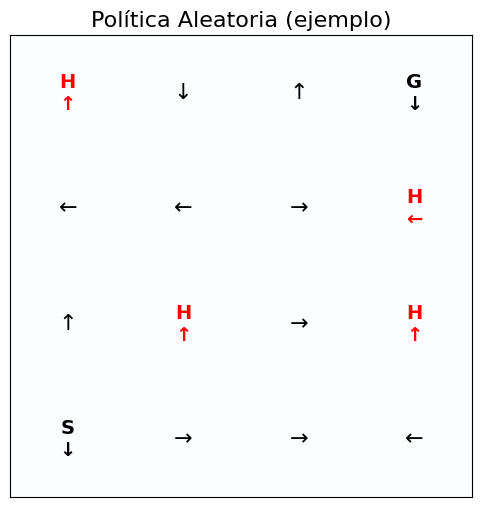

In [11]:

visualizar_politica(politica_aleatoria, "Política Aleatoria (ejemplo)")

## Politica Q-learning

In [12]:
class QLearningTabular:
  """Implementación de Q-Learning con tabla Q explícita"""
  def __init__(self, n_estados, n_acciones, lr=0.1, gamma=0.95, epsilon=1.0):
      self.n_estados = n_estados
      self.n_acciones = n_acciones
      self.lr = lr  # learning rate
      self.gamma = gamma  # factor de descuento
      self.epsilon = epsilon  # exploración inicial
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.nombre = "Q-Learning Tabular"

      # Inicializar tabla Q
      self.q_table = np.zeros((n_estados, n_acciones))

      # Para tracking
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción con epsilon-greedy"""
      if entrenando and np.random.random() < self.epsilon:
          return np.random.randint(self.n_acciones)  # Exploración
      else:
          return np.argmax(self.q_table[estado])  # Explotación

  def actualizar_q(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Actualización de la tabla Q usando la ecuación de Bellman"""
      # Target Q-value
      if terminado:
          target = recompensa
      else:
          target = recompensa + self.gamma * np.max(self.q_table[siguiente_estado])

      # Actualización Q-Learning
      self.q_table[estado, accion] += self.lr * (target - self.q_table[estado, accion])

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener la política greedy de la tabla Q"""
      return np.argmax(self.q_table, axis=1)

  def entrenar(self, env, episodios=10000):
      """Entrenamiento del agente Q-Learning"""
      print(f"🧠 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)  # Para promedios móviles

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Actualizar tabla Q
              self.actualizar_q(estado, accion, recompensa, siguiente_estado, terminado)

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 1000 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito (últimos 100) = {tasa_exito:.3f}, Epsilon = {self.epsilon:.3f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado sin exploración"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)  # Sin exploración
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Crear y entrenar agente Q-Learning

In [13]:

agente_qlearning = QLearningTabular(env.observation_space.n, env.action_space.n,lr=0.1, gamma=0.95, epsilon=1.0)
recompensas_qlearning = agente_qlearning.entrenar(env, episodios=1000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.000, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


## Evaluar agente entrenado

In [14]:

tasa_exito_qlearning, _ = agente_qlearning.evaluar(env, episodios=1000)


📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.000
Pasos promedio: 18.5


## Visualizar política aprendida

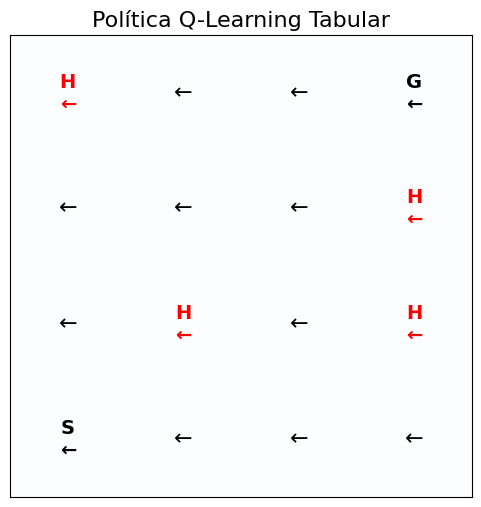

In [15]:

politica_qlearning = agente_qlearning.obtener_politica()
visualizar_politica(politica_qlearning, "Política Q-Learning Tabular")

## Visualizar tabla Q como heatmap

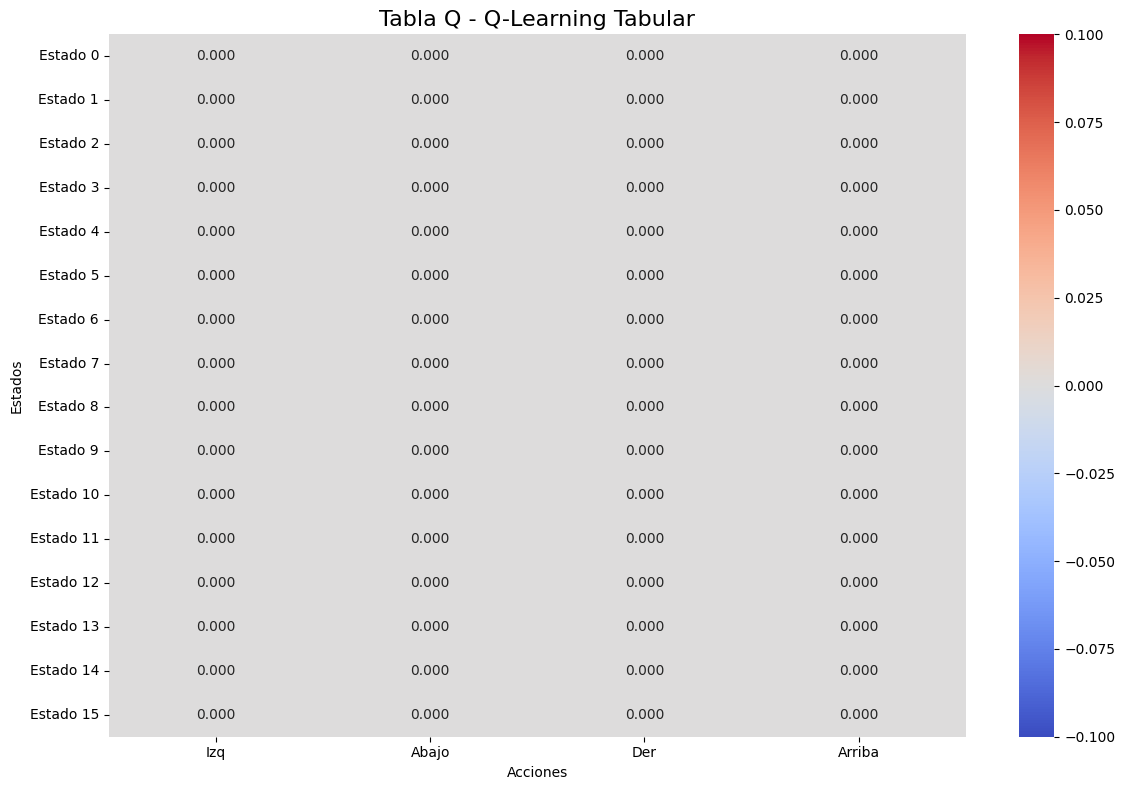

In [16]:

plt.figure(figsize=(12, 8))
sns.heatmap(agente_qlearning.q_table, annot=True, fmt='.3f', cmap='coolwarm',
xticklabels=['Izq', 'Abajo', 'Der', 'Arriba'],
yticklabels=[f'Estado {i}' for i in range(16)])
plt.title('Tabla Q - Q-Learning Tabular', fontsize=16)
plt.xlabel('Acciones')
plt.ylabel('Estados')
plt.tight_layout()
plt.show()

## Mostrar valores Q para estados importantes
-

In [17]:
print("🎯 VALORES Q PARA ESTADOS CLAVE:")
print("-" * 40)
estados_clave = [0, 5, 7, 11, 12, 14, 15]  # Start, Holes, Goal
acciones_nombres = ['Izquierda', 'Abajo', 'Derecha', 'Arriba']
for estado in estados_clave:
  if estado == 0:
    tipo = "START"
  elif estado == 15:
    tipo = "GOAL"
  elif estado in [5, 7, 11, 12]:
    tipo = "HOLE"
  else:
    tipo = "NORMAL"

print(f"\nEstado {estado} ({tipo}):")
for accion, valor in enumerate(agente_qlearning.q_table[estado]):
    print(f"  {acciones_nombres[accion]}: {valor:.3f}")

🎯 VALORES Q PARA ESTADOS CLAVE:
----------------------------------------

Estado 15 (GOAL):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000


# Deep Q-Network

## red DQN

In [18]:
class DQN(nn.Module):
  """Red neuronal para aproximar la función Q"""
  def __init__(self, input_size, hidden_size, output_size):
      super(DQN, self).__init__()
      self.network = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size)
      )

  def forward(self, x):
      return self.network(x)

## DQNAgent

In [19]:
class DQNAgent:
  """Agente Deep Q-Network con Experience Replay y Target Network"""
  def __init__(self, state_size, action_size, lr=0.001, gamma=0.95, epsilon=1.0):
      self.state_size = state_size
      self.action_size = action_size
      self.gamma = gamma
      self.epsilon = epsilon
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.learning_rate = lr
      self.nombre = "Deep Q-Network (DQN)"

      # Configuración del dispositivo
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"🖥️ Usando dispositivo: {self.device}")

      # Redes neuronales
      hidden_size = 128
      self.q_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.target_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

      # Inicializar target network con mismos pesos
      self.update_target_network()

      # Experience Replay
      self.memory = deque(maxlen=10000)
      self.batch_size = 32

      # Frecuencia de actualización de target network
      self.update_target_frequency = 100
      self.step_count = 0

      # Para tracking
      self.losses = []
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def state_to_onehot(self, state):
      """Convertir estado discreto a representación one-hot"""
      onehot = np.zeros(self.state_size)
      onehot[state] = 1.0
      return onehot

  def remember(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Almacenar experiencia en el buffer de replay"""
      estado_onehot = self.state_to_onehot(estado)
      siguiente_estado_onehot = self.state_to_onehot(siguiente_estado)

      self.memory.append((estado_onehot, accion, recompensa, siguiente_estado_onehot, terminado))

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción epsilon-greedy usando la red neuronal"""
      if entrenando and np.random.random() < self.epsilon:
          return random.randrange(self.action_size)

      # Convertir estado a tensor
      estado_onehot = self.state_to_onehot(estado)
      estado_tensor = torch.FloatTensor(estado_onehot).unsqueeze(0).to(self.device)

      # Forward pass
      with torch.no_grad():
          q_values = self.q_network(estado_tensor)

      return np.argmax(q_values.cpu().data.numpy())

  def replay(self):
      """Experience replay para entrenar la red"""
      if len(self.memory) < self.batch_size:
          return

      # Muestrear batch aleatorio
      batch = random.sample(self.memory, self.batch_size)
      estados = torch.FloatTensor([e[0] for e in batch]).to(self.device)
      acciones = torch.LongTensor([e[1] for e in batch]).to(self.device)
      recompensas = torch.FloatTensor([e[2] for e in batch]).to(self.device)
      siguientes_estados = torch.FloatTensor([e[3] for e in batch]).to(self.device)
      terminados = torch.BoolTensor([e[4] for e in batch]).to(self.device)

      # Q-values actuales
      current_q_values = self.q_network(estados).gather(1, acciones.unsqueeze(1))

      # Q-values objetivo usando target network
      with torch.no_grad():
          next_q_values = self.target_network(siguientes_estados).max(1)[0]
          target_q_values = recompensas + (self.gamma * next_q_values * ~terminados)

      # Calcular pérdida
      loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

      # Backpropagation
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Guardar pérdida para análisis
      self.losses.append(loss.item())

  def update_target_network(self):
      """Actualizar la target network con pesos de la red principal"""
      self.target_network.load_state_dict(self.q_network.state_dict())

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener política greedy de la red entrenada"""
      politica = []
      for estado in range(self.state_size):
          accion = self.seleccionar_accion(estado, entrenando=False)
          politica.append(accion)
      return np.array(politica)

  def entrenar(self, env, episodios=2000):
      """Entrenamiento del agente DQN"""
      print(f"🤖 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Almacenar experiencia
              self.remember(estado, accion, recompensa, siguiente_estado, terminado)

              # Entrenar la red
              self.replay()

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1
              self.step_count += 1

              # Actualizar target network periódicamente
              if self.step_count % self.update_target_frequency == 0:
                  self.update_target_network()

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 200 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              loss_promedio = np.mean(self.losses[-100:]) if len(self.losses) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito = {tasa_exito:.3f}, "
                    f"Epsilon = {self.epsilon:.3f}, Loss = {loss_promedio:.4f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Entrenar deep DQN

In [20]:
agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n,
lr=0.001, gamma=0.95, epsilon=1.0)
recompensas_dqn = agente_dqn.entrenar(env, episodios=1000)

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.070, Epsilon = 0.367, Loss = 0.0079
Episodio 400: Tasa éxito = 0.170, Epsilon = 0.135, Loss = 0.0066
Episodio 600: Tasa éxito = 0.390, Epsilon = 0.049, Loss = 0.0080
Episodio 800: Tasa éxito = 0.460, Epsilon = 0.018, Loss = 0.0078
Episodio 1000: Tasa éxito = 0.560, Epsilon = 0.010, Loss = 0.0076

✅ Entrenamiento Deep Q-Network (DQN) completado!


## Evaluar agente Deep DQN

In [21]:
tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)


📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.729
Pasos promedio: 40.4


## Visualizar política aprendida

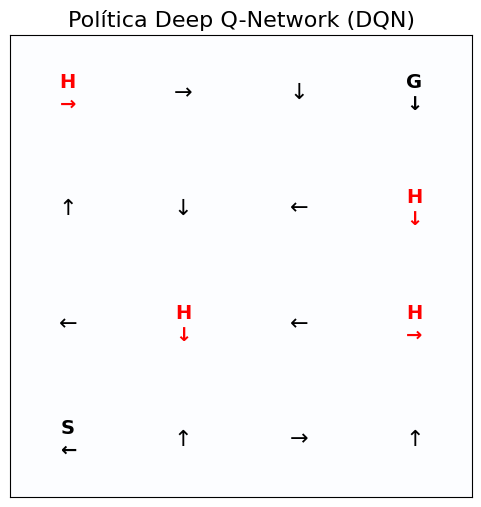

In [22]:

politica_dqn = agente_dqn.obtener_politica()
visualizar_politica(politica_dqn, "Política Deep Q-Network (DQN)")


# Comparación de resultados

## Comparación final tasa de éxito

In [23]:
print("🏆 COMPARACIÓN FINAL DE AGENTES")
print("=" * 50)
print(f"Política Aleatoria:    Tasa de éxito = {tasa_exito_aleatorio:.3f}")
print(f"Q-Learning Tabular:    Tasa de éxito = {tasa_exito_qlearning:.3f}")
print(f"Deep Q-Network (DQN):  Tasa de éxito = {tasa_exito_dqn:.3f}")

🏆 COMPARACIÓN FINAL DE AGENTES
Política Aleatoria:    Tasa de éxito = 0.011
Q-Learning Tabular:    Tasa de éxito = 0.000
Deep Q-Network (DQN):  Tasa de éxito = 0.729


## Crear gráficas de comparación


Crear gráficas de comparación


### 1. Curvas de aprendizaje

In [24]:
len(recompensas_aleatorio)

1000

In [25]:
len(recompensas_qlearning)

1000

In [26]:
len(recompensas_dqn)

1000

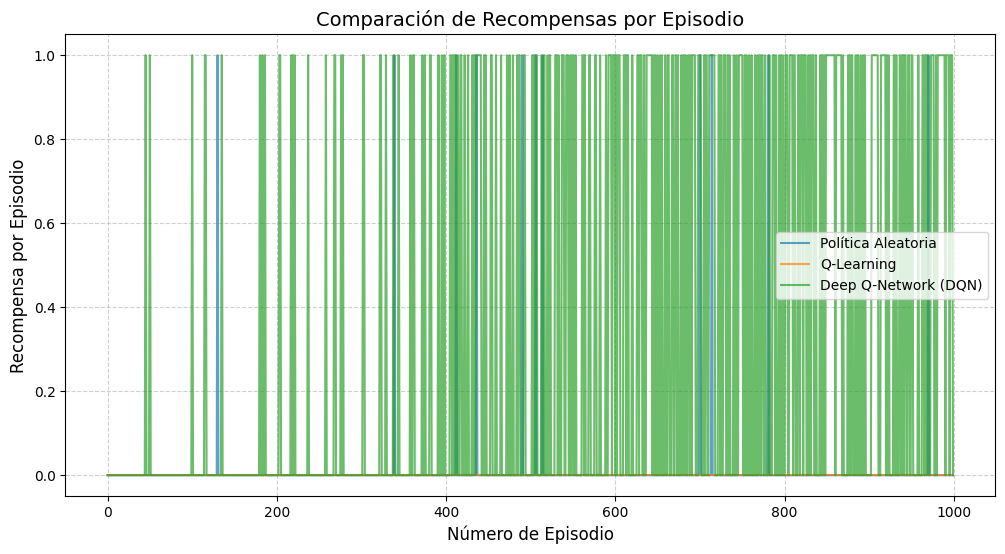

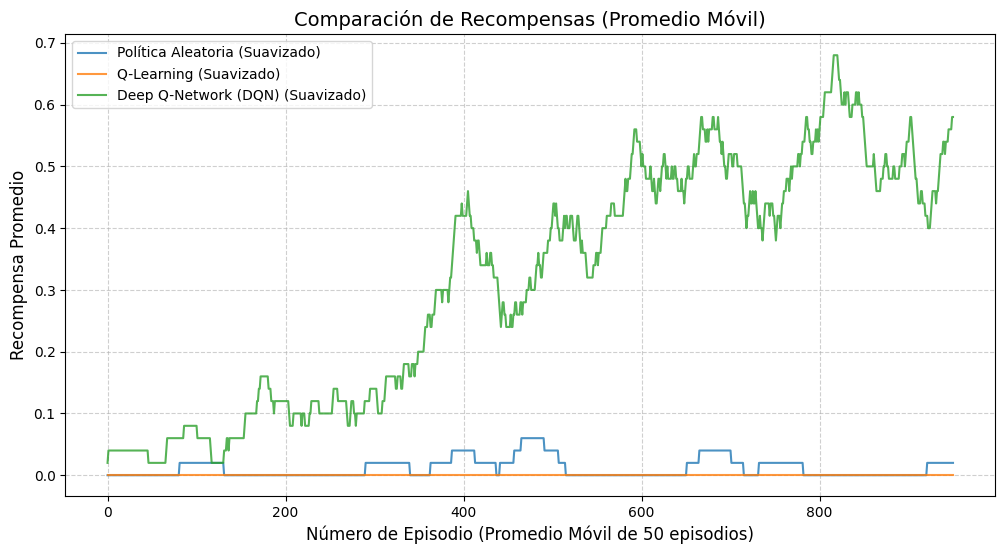

In [27]:
# prompt: crear gráfico que compare recompensas_aleatorio, recompensas_qlearning y recompensas_dqn. Eje x es nro de episodio y el eje Y valor de la recompensa

import matplotlib.pyplot as plt
import numpy as np
# Asegurar que las listas de recompensas tengan la misma longitud para la gráfica
# Tomaremos la longitud mínima si son diferentes
min_len = min(len(recompensas_aleatorio), len(recompensas_qlearning), len(recompensas_dqn))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio[:min_len], label='Política Aleatoria', alpha=0.7)
plt.plot(recompensas_qlearning[:min_len], label='Q-Learning', alpha=0.7)
plt.plot(recompensas_dqn[:min_len], label='Deep Q-Network (DQN)', alpha=0.7)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Recompensa por Episodio', fontsize=12)
plt.title('Comparación de Recompensas por Episodio', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Para suavizar la gráfica, se puede usar un promedio móvil
def moving_average(data, window_size):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 50  # Tamaño de la ventana para el promedio móvil

recompensas_aleatorio_suavizado = moving_average(recompensas_aleatorio, window)
recompensas_qlearning_suavizado = moving_average(recompensas_qlearning, window)
recompensas_dqn_suavizado = moving_average(recompensas_dqn, window)

# Ajustar la longitud mínima para las series suavizadas
min_len_suavizado = min(len(recompensas_aleatorio_suavizado), len(recompensas_qlearning_suavizado), len(recompensas_dqn_suavizado))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio_suavizado[:min_len_suavizado], label='Política Aleatoria (Suavizado)', alpha=0.8)
plt.plot(recompensas_qlearning_suavizado[:min_len_suavizado], label='Q-Learning (Suavizado)', alpha=0.8)
plt.plot(recompensas_dqn_suavizado[:min_len_suavizado], label='Deep Q-Network (DQN) (Suavizado)', alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Recompensas (Promedio Móvil)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



### 2. Comparación de tasas de éxito

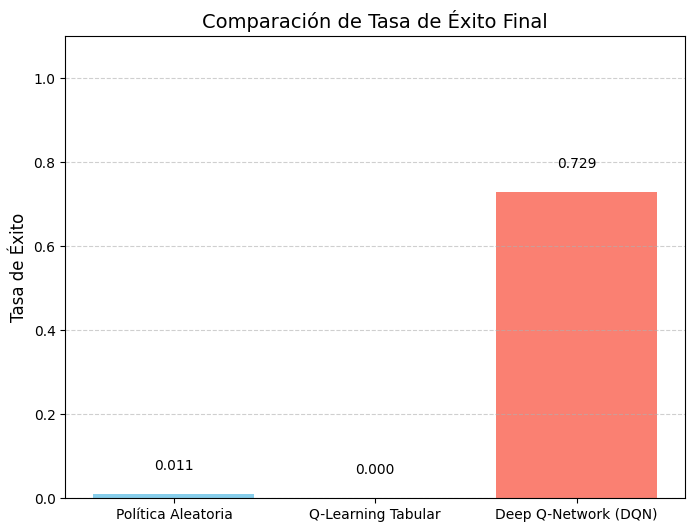

In [28]:
# prompt: comparar tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn en un gráfico de barras

import matplotlib.pyplot as plt
metricas = ['Política Aleatoria', 'Q-Learning Tabular', 'Deep Q-Network (DQN)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Evolución de Epsilon (solo para algoritmos que usan exploración)

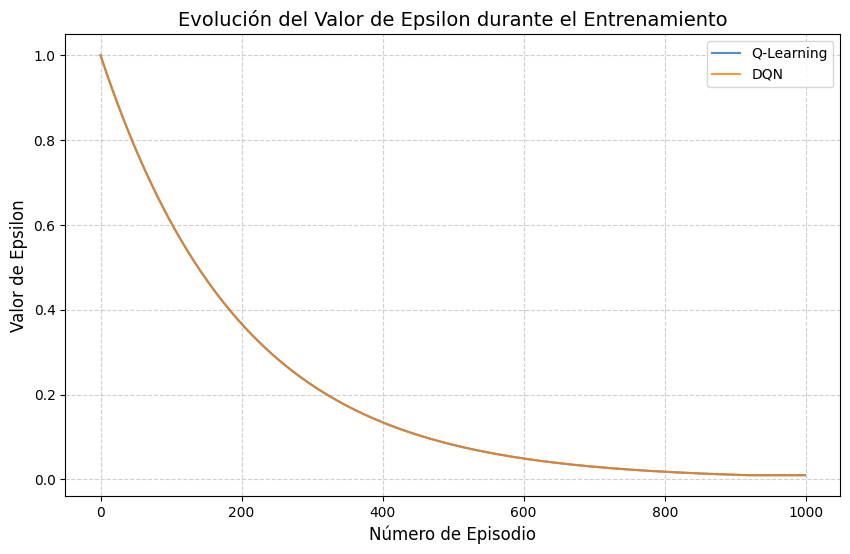

In [29]:
# prompt: Crear un gráfico para comparar agente_qlearning.epsilons y agente_qlearning.epsilons siendo x el nro de episodios y el eje Y el valor de epsilon

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agente_qlearning.epsilons, label='Q-Learning', alpha=0.8)
plt.plot(agente_dqn.epsilons, label='DQN', alpha=0.8)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### DQN pérdida

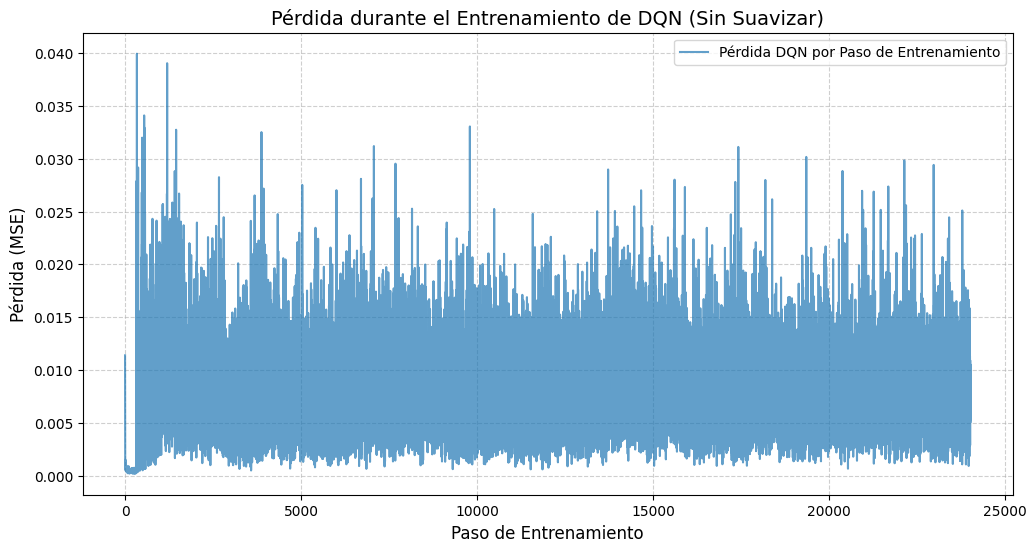

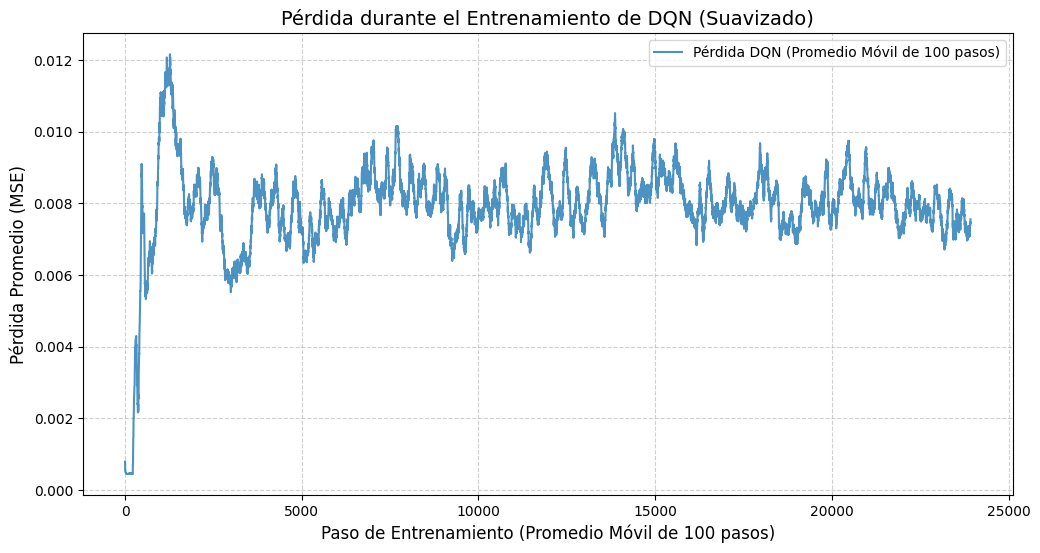

In [30]:
# prompt: Graficar agente_dqn.losses que representa la pérdida durante el entrenamiento de DQN. Mostrar con y sin promedio móvil

import matplotlib.pyplot as plt
# Graficar la pérdida del agente DQN
plt.figure(figsize=(12, 6))
plt.plot(agente_dqn.losses, label='Pérdida DQN por Paso de Entrenamiento', alpha=0.7)
plt.xlabel('Paso de Entrenamiento', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Sin Suavizar)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Graficar la pérdida con promedio móvil para suavizar
window_loss = 100 # Tamaño de la ventana para el promedio móvil de la pérdida
losses_dqn_suavizado = moving_average(agente_dqn.losses, window_loss)

plt.figure(figsize=(12, 6))
plt.plot(losses_dqn_suavizado, label=f'Pérdida DQN (Promedio Móvil de {window_loss} pasos)', alpha=0.8)
plt.xlabel(f'Paso de Entrenamiento (Promedio Móvil de {window_loss} pasos)', fontsize=12)
plt.ylabel('Pérdida Promedio (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Suavizado)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Ejercitación

## A) Modifique el entrenamiento de los agentes para entrenar por más episodios. Evalue su desempeño. ¿ Mejora o empeora ?






 A) Modificación del entrenamiento a 3000 episodios

In [49]:
# Entrenar agente Q-Learning con 3000 episodios
agente_qlearning_3000 = QLearningTabular(env.observation_space.n, env.action_space.n, lr=0.1, gamma=0.95, epsilon=1.0)
recompensas_qlearning_3000 = agente_qlearning_3000.entrenar(env, episodios=3000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.640, Epsilon = 0.010
Episodio 2000: Tasa éxito (últimos 100) = 0.730, Epsilon = 0.010
Episodio 3000: Tasa éxito (últimos 100) = 0.690, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


In [50]:
# Evaluar agente Q-Learning entrenado por 3000 episodios
tasa_exito_qlearning_3000, _ = agente_qlearning_3000.evaluar(env, episodios=1000) # Evaluamos con 1000 episodios

📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.724
Pasos promedio: 40.7


In [52]:
# Entrenar agente DQN con 3000 episodios
agente_dqn_3000 = DQNAgent(env.observation_space.n, env.action_space.n, lr=0.001, gamma=0.95, epsilon=1.0)
recompensas_dqn_3000 = agente_dqn_3000.entrenar(env, episodios=3000)

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.030, Epsilon = 0.367, Loss = 0.0056
Episodio 400: Tasa éxito = 0.130, Epsilon = 0.135, Loss = 0.0051
Episodio 600: Tasa éxito = 0.300, Epsilon = 0.049, Loss = 0.0077
Episodio 800: Tasa éxito = 0.620, Epsilon = 0.018, Loss = 0.0080
Episodio 1000: Tasa éxito = 0.500, Epsilon = 0.010, Loss = 0.0078
Episodio 1200: Tasa éxito = 0.540, Epsilon = 0.010, Loss = 0.0065
Episodio 1400: Tasa éxito = 0.630, Epsilon = 0.010, Loss = 0.0077
Episodio 1600: Tasa éxito = 0.450, Epsilon = 0.010, Loss = 0.0091
Episodio 1800: Tasa éxito = 0.580, Epsilon = 0.010, Loss = 0.0079
Episodio 2000: Tasa éxito = 0.590, Epsilon = 0.010, Loss = 0.0082
Episodio 2200: Tasa éxito = 0.590, Epsilon = 0.010, Loss = 0.0090
Episodio 2400: Tasa éxito = 0.530, Epsilon = 0.010, Loss = 0.0075
Episodio 2600: Tasa éxito = 0.440, Epsilon = 0.010, Loss = 0.0072
Episodio 2800: Tasa éxito = 0.590, Epsilon = 0.010, Loss = 0.0075
Episodio 3000: T

In [58]:
# Evaluar agente DQN entrenado por 3000 episodios
tasa_exito_dqn_3000, _ = agente_dqn_3000.evaluar(env, episodios=1000) # Evaluamos con 1000 episodios

📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.601
Pasos promedio: 36.7


In [59]:
# Re-evaluamos la política aleatoria para tenerla en la comparación
agente_aleatorio_eval_3000 = PoliticaAleatoria(env.action_space.n)
_, tasa_exito_aleatorio_eval_3000 = agente_aleatorio_eval_3000.entrenar(env, episodios=1000)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.005
Episodio 400: Tasa de éxito = 0.007
Episodio 600: Tasa de éxito = 0.010
Episodio 800: Tasa de éxito = 0.010
Episodio 1000: Tasa de éxito = 0.009

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.009
Recompensa promedio: 0.009


 Comparación de resultados con 3000 episodios de entrenamiento

In [63]:
print("🏆 COMPARACIÓN FINAL DE AGENTES (con 1000 y 3000 episodios de entrenamiento)")
print("=" * 75)

print(f"{'Agente':<30} | {'Tasa de Éxito (1000 Episodios)':<30} | {'Tasa de Éxito (3000 Episodios)':<30}")
print("-" * 75)
print(f"{'Política Aleatoria':<30} | {tasa_exito_aleatorio:<30.3f} | {tasa_exito_aleatorio_eval_3000:<30.3f}")
print(f"{'Q-Learning Tabular':<30} | {tasa_exito_qlearning:<30.3f} | {tasa_exito_qlearning_3000:<30.3f}")
print(f"{'Deep Q-Network (DQN)':<30} | {tasa_exito_dqn:<30.3f} | {tasa_exito_dqn_3000:<30.3f}")

🏆 COMPARACIÓN FINAL DE AGENTES (con 1000 y 3000 episodios de entrenamiento)
Agente                         | Tasa de Éxito (1000 Episodios) | Tasa de Éxito (3000 Episodios)
---------------------------------------------------------------------------
Política Aleatoria             | 0.011                          | 0.009                         
Q-Learning Tabular             | 0.000                          | 0.724                         
Deep Q-Network (DQN)           | 0.729                          | 0.601                         


In [61]:
import plotly.express as px
import pandas as pd

# Crear un DataFrame para Plotly Express con datos de ambos entrenamientos
data = {'Agente': ['Política Aleatoria (1000)', 'Q-Learning Tabular (1000)', 'Deep Q-Network (DQN) (1000)',
                   'Política Aleatoria (3000)', 'Q-Learning Tabular (3000)', 'Deep Q-Network (DQN) (3000)'],
        'Tasa de Éxito': [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn,
                          tasa_exito_aleatorio_eval_3000, tasa_exito_qlearning_3000, tasa_exito_dqn_3000],
        'Episodios de Entrenamiento': ['1000'] * 3 + ['3000'] * 3 # Columna para agrupar
        }
df_comparacion_episodios = pd.DataFrame(data)

# Crear el gráfico de barras interactivo agrupado
fig = px.bar(df_comparacion_episodios, x='Agente', y='Tasa de Éxito',
             color='Episodios de Entrenamiento', # Agrupar por número de episodios
             barmode='group', # Mostrar barras agrupadas
             title='Comparación de Tasa de Éxito por Agente y Episodios de Entrenamiento',
             labels={'Tasa de Éxito': 'Tasa de Éxito'},
             text='Tasa de Éxito' # Mostrar el valor encima de cada barra
             )

# Ajustar el rango del eje Y para mejor visualización
fig.update_layout(yaxis_range=[0, 1.1])

# Formato del texto encima de las barras
fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')

fig.show()

Al entrenar más episodios, el Q-Learning Tabular mejoró mucho, mostrando que necesitaba más tiempo para aprender una buena política.
El DQN bajó un poco su rendimiento, posiblemente por sobreajuste o mala configuración de parámetros.
La política aleatoria se mantuvo igual, ya que no aprende del entorno.
En general, entrenar más ayuda, pero depende del tipo de agente y de cómo se ajustan sus parámetros.

## B) Considere modificar el modelo DQN el hiperparámetro gamma: un valor bajo, uno medio y uno alto. Entrene los tres modelos y compare los resultados. Comparta sus conclusiones

In [38]:
# Valores de gamma a probar
gammas = [0.2, 0.6, 0.99] # Bajo, Medio, Alto
agentes_dqn_gamma = {}

for gamma_val in gammas:
    # Crear agente DQN con el valor de gamma actual
    agente = DQNAgent(env.observation_space.n, env.action_space.n,
                      lr=0.001, gamma=gamma_val, epsilon=1.0)

    # Almacenar el agente
    agentes_dqn_gamma[gamma_val] = agente

🖥️ Usando dispositivo: cpu
🖥️ Usando dispositivo: cpu
🖥️ Usando dispositivo: cpu


In [39]:
# Entrenar Agentes DQN con diferentes valores de Gamma

print("\n--- Entrenando Agentes DQN con diferentes valores de Gamma ---")

recompensas_dqn_gamma = {}

for gamma_val, agente in agentes_dqn_gamma.items():
    print(f"\nEntrenando Agente DQN con gamma = {gamma_val}")
    recompensas = agente.entrenar(env, episodios=1000) # Entrenar con 1000 episodios
    recompensas_dqn_gamma[gamma_val] = recompensas

print("\n✅ Entrenamiento de agentes DQN con diferentes gamma completado!")


--- Entrenando Agentes DQN con diferentes valores de Gamma ---

Entrenando Agente DQN con gamma = 0.2
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.010, Epsilon = 0.367, Loss = 0.0024
Episodio 400: Tasa éxito = 0.040, Epsilon = 0.135, Loss = 0.0022
Episodio 600: Tasa éxito = 0.010, Epsilon = 0.049, Loss = 0.0026
Episodio 800: Tasa éxito = 0.030, Epsilon = 0.018, Loss = 0.0024
Episodio 1000: Tasa éxito = 0.050, Epsilon = 0.010, Loss = 0.0019

✅ Entrenamiento Deep Q-Network (DQN) completado!

Entrenando Agente DQN con gamma = 0.6
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0016
Episodio 400: Tasa éxito = 0.060, Epsilon = 0.135, Loss = 0.0028
Episodio 600: Tasa éxito = 0.050, Epsilon = 0.049, Loss = 0.0031
Episodio 800: Tasa éxito = 0.070, Epsilon = 0.018, Loss = 0.0028
Episodio 1000: Tasa éxito = 0.040, Epsilon = 0.010, Loss = 0.0033

✅ Entrenamiento Deep Q-Network (DQN) completado!

Entrenando Agente DQN con gamma

In [56]:
# Evaluar Agentes DQN con diferentes valores de Gamma

print("\n--- Evaluando Agentes DQN con diferentes valores de Gamma ---")

tasas_exito_dqn_gamma = {}

for gamma_val, agente in agentes_dqn_gamma.items():
    print(f"\nEvaluando Agente DQN con gamma = {gamma_val}")
    tasa_exito, _ = agente.evaluar(env, episodios=1000) # Evaluar con 1000 episodios
    tasas_exito_dqn_gamma[gamma_val] = tasa_exito

print("\n✅ Evaluación de agentes DQN con diferentes gamma completada!")


--- Evaluando Agentes DQN con diferentes valores de Gamma ---

Evaluando Agente DQN con gamma = 0.2
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.053
Pasos promedio: 5.0

Evaluando Agente DQN con gamma = 0.6
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.078
Pasos promedio: 6.4

Evaluando Agente DQN con gamma = 0.99
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.751
Pasos promedio: 44.5

✅ Evaluación de agentes DQN con diferentes gamma completada!


In [62]:
import plotly.express as px
import pandas as pd

# Crear un DataFrame para Plotly Express
data_gamma = {'Gamma': list(tasas_exito_dqn_gamma.keys()),
              'Tasa de Éxito': list(tasas_exito_dqn_gamma.values())}
df_gamma_comparacion = pd.DataFrame(data_gamma)

# Crear el gráfico de barras interactivo
fig_gamma = px.bar(df_gamma_comparacion, x='Gamma', y='Tasa de Éxito',
                   title='Comparación de Tasa de Éxito por valor de Gamma (DQN)',
                   labels={'Tasa de Éxito': 'Tasa de Éxito', 'Gamma': 'Valor de Gamma'},
                   text='Tasa de Éxito',
                   color='Gamma'
                  )

fig_gamma.update_layout(yaxis_range=[0, 1.1])
fig_gamma.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_gamma.show()

Al variar el valor de gamma, se nota que el desempeño mejora mucho cuando el agente valora más las recompensas futuras.

Con gamma = 0.2 y 0.6, el DQN casi no aprende (tasa de éxito muy baja), porque se enfoca solo en recompensas inmediatas.

En cambio, con gamma = 0.99 el agente logra una tasa de éxito alta (0.751), mostrando que aprende estrategias más largas y efectivas.

## C) Lo mismo que en B) pero para el hiperparámetro alpha.

In [44]:
# C) Modificar el hiperparámetro alpha (learning rate) del modelo DQN

print("\n--- C) Comparación de Agentes DQN con diferentes valores de Alpha (Learning Rate) ---")

# Valores de alpha a probar
alphas = [0.01, 0.001, 0.0001] # Alto, Medio, Bajo
agentes_dqn_alpha = {}
tasas_exito_dqn_alpha = {}
recompensas_dqn_alpha = {}

for alpha_val in alphas:
    print(f"\nEntrenando Agente DQN con alpha = {alpha_val}")
    # Crear y entrenar agente DQN con el valor de alpha actual
    agente = DQNAgent(env.observation_space.n, env.action_space.n,
                      lr=alpha_val, gamma=0.95, epsilon=1.0)
    recompensas = agente.entrenar(env, episodios=1000)

    # Evaluar el agente entrenado
    tasa_exito, _ = agente.evaluar(env, episodios=1000)
    # Almacenar resultados
    agentes_dqn_alpha[alpha_val] = agente
    tasas_exito_dqn_alpha[alpha_val] = tasa_exito
    recompensas_dqn_alpha[alpha_val] = recompensas


# Mostrar comparación final
print("\n🏆 COMPARACIÓN DE TASA DE ÉXITO POR VALOR DE ALPHA:")
print("=" * 50)
for alpha_val, tasa in tasas_exito_dqn_alpha.items():
    print(f"Alpha = {alpha_val}: Tasa de éxito = {tasa:.3f}")




--- C) Comparación de Agentes DQN con diferentes valores de Alpha (Learning Rate) ---

Entrenando Agente DQN con alpha = 0.01
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0119
Episodio 400: Tasa éxito = 0.230, Epsilon = 0.135, Loss = 0.0079
Episodio 600: Tasa éxito = 0.320, Epsilon = 0.049, Loss = 0.0077
Episodio 800: Tasa éxito = 0.290, Epsilon = 0.018, Loss = 0.0103
Episodio 1000: Tasa éxito = 0.280, Epsilon = 0.010, Loss = 0.0090

✅ Entrenamiento Deep Q-Network (DQN) completado!
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.200
Pasos promedio: 15.1

Entrenando Agente DQN con alpha = 0.001
🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0050
Episodio 400: Tasa éxito = 0.200, Epsilon = 0.135, Loss = 0.0060
Episodio 600: Tasa éxito = 0.430, Epsilon = 0.049, Loss = 0.0086
Episodio 800: Tasa éxito = 0.480, Epsilon = 0.018, Loss

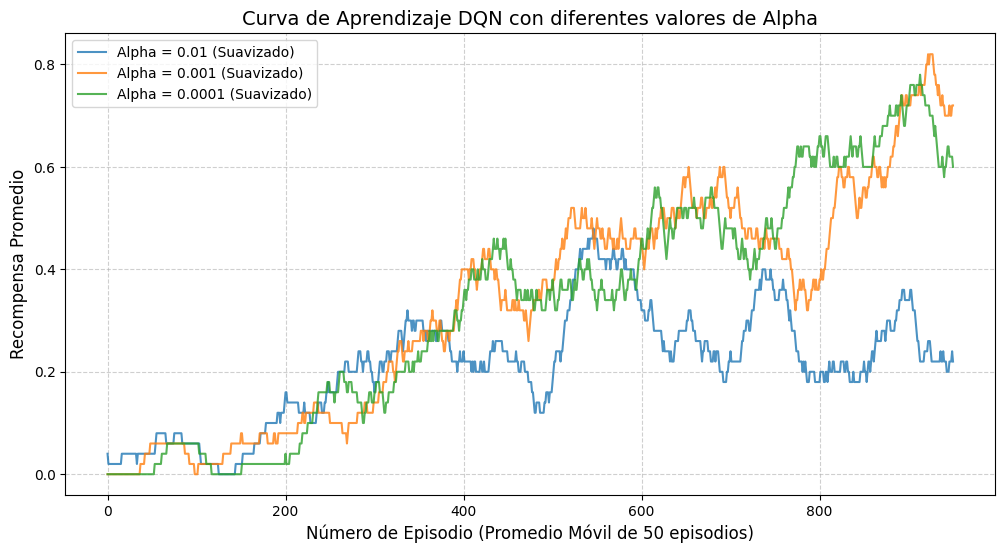

In [45]:
# Opcional: Visualizar curvas de aprendizaje (recompensas)
plt.figure(figsize=(12, 6))
for alpha_val, recompensas in recompensas_dqn_alpha.items():
    plt.plot(moving_average(recompensas, 50), label=f'Alpha = {alpha_val} (Suavizado)', alpha=0.8)

plt.xlabel('Número de Episodio (Promedio Móvil de 50 episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Curva de Aprendizaje DQN con diferentes valores de Alpha', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Opcional: Visualizar tasas de éxito en un gráfico de barras
import plotly.express as px
import pandas as pd

data_alpha = {'Alpha': list(tasas_exito_dqn_alpha.keys()),
              'Tasa de Éxito': list(tasas_exito_dqn_alpha.values())}
df_alpha_comparacion = pd.DataFrame(data_alpha)

fig_alpha = px.bar(df_alpha_comparacion, x='Alpha', y='Tasa de Éxito',
                   title='Comparación de Tasa de Éxito por valor de Alpha (DQN)',
                   labels={'Tasa de Éxito': 'Tasa de Éxito', 'Alpha': 'Valor de Alpha'},
                   text='Tasa de Éxito',
                   color='Alpha'
                  )

fig_alpha.update_layout(yaxis_range=[0, 1.1])
fig_alpha.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_alpha.show()

Con alpha = 0.01, el aprendizaje fue inestable y el agente tuvo bajo rendimiento.

Con alpha = 0.001, se obtuvo la mejor tasa de éxito (0.435), mostrando un equilibrio entre aprender rápido y mantener estabilidad.

Con alpha = 0.0001, el avance fue más lento y el rendimiento bajó un poco.